In [1]:
# Importing necessary libraries.
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D, Dense, Multiply, Reshape, Add, Activation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import cv2
import os
import pandas as pd
from PIL import Image
import imagehash
import shutil
from collections import defaultdict
from sklearn.model_selection import train_test_split
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [3]:
# Constants
IMG_SIZE = (299, 299)  # Size for InceptionV3 and Xception
BATCH_SIZE = 16        # Batch size for training
EPOCHS = 20            # Maximum number of training epochs
original_dataset  = "./Dataset"
DATA_PATH = "./new_data"

In [4]:
#to remove corrupted images from directory
def clean_corrupted_images(directory):
    corrupted_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Verify if it's an image
                    img.close()
                except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
                    print(f'Removing corrupted file: {file_path}')
                    os.remove(file_path)
                    corrupted_count += 1
    return corrupted_count

In [5]:
# Prepare dataset with perceptual hashing duplicate detection
def prepare_dataset_with_duplicate_removal():
    
    # Clean original dataset
    print("="*60)
    print("Cleaning corrupted images in original dataset...")
    print("="*60)
    corrupted_count = 0
    for class_name in ['infected', 'noninfected']:
        class_dir = os.path.join(original_dataset, class_name)
        count = clean_corrupted_images(class_dir)
        print(f"Removed {count} corrupted images from {class_name}")
        corrupted_count += count
    print(f"Total corrupted images removed: {corrupted_count}")

    # Collect image paths and classes
    image_records = []
    for class_name in ['infected', 'noninfected']:
        class_dir = os.path.join(original_dataset, class_name)
        files = [f for f in os.listdir(class_dir)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for file in files:
            file_path = os.path.join(class_dir, file)
            image_records.append((file_path, class_name))

    # Compute hashes with progress
    print("\n" + "="*60)
    print("Detecting duplicates with hashing...")
    print(f"Processing {len(image_records)} images")
    print("="*60)

    # Define a named function for hashing
    def compute_hash(file_path):
        try:
            with Image.open(file_path) as img:
                # Use faster average hash instead of dHash
                return str(imagehash.average_hash(img))
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return None

    # Process images sequentially with progress
    hash_map = {}
    for file_path, class_name in tqdm(image_records, desc="Hashing images"):
        img_hash = compute_hash(file_path)
        if img_hash:
            if img_hash not in hash_map:
                hash_map[img_hash] = []
            hash_map[img_hash].append((file_path, class_name))

    # Identify duplicates and conflicts
    print("\nIdentifying duplicates...")
    unique_images = []
    duplicate_count = 0
    conflict_count = 0

    for img_hash, items in tqdm(hash_map.items(), desc="Processing hashes"):
        if len(items) > 1:
            classes = {item[1] for item in items}

            # Handle same-class duplicates
            if len(classes) == 1:
                # Keep the first occurrence
                unique_images.append(items[0])
                duplicate_count += (len(items) - 1)
            # Handle cross-class conflicts
            else:
                conflict_count += len(items)
                print(f"\nConflict found: {len(items)} images with same hash")
                for item in items:
                    print(f" - {item[0]} ({item[1]})")
        else:
            unique_images.append(items[0])

    print(f"\nTotal duplicates removed: {duplicate_count}")
    print(f"Total conflicting images removed: {conflict_count}")
    print(f"Unique images remaining: {len(unique_images)}")

    # Split data into train/validation/test (60/20/20)
    infected = [item for item in unique_images if item[1] == 'infected']
    noninfected = [item for item in unique_images if item[1] == 'noninfected']

    print(f"\nSplitting data: {len(infected)} infected, {len(noninfected)} noninfected")

    # Split infected
    infected_train, infected_temp = train_test_split(infected, test_size=0.4, random_state=42)
    infected_val, infected_test = train_test_split(infected_temp, test_size=0.5, random_state=42)

    # Split noninfected
    noninfected_train, noninfected_temp = train_test_split(noninfected, test_size=0.4, random_state=42)
    noninfected_val, noninfected_test = train_test_split(noninfected_temp, test_size=0.5, random_state=42)

    print(f"Train: {len(infected_train)} infected, {len(noninfected_train)} noninfected")
    print(f"Validation: {len(infected_val)} infected, {len(noninfected_val)} noninfected")
    print(f"Test: {len(infected_test)} infected, {len(noninfected_test)} noninfected")

    # Create dataset structure
    print("\n" + "="*60)
    print("Creating dataset structure...")
    print("="*60)
    os.makedirs(os.path.join(DATA_PATH, "train", "infected"), exist_ok=True)
    os.makedirs(os.path.join(DATA_PATH, "train", "noninfected"), exist_ok=True)
    os.makedirs(os.path.join(DATA_PATH, "val", "infected"), exist_ok=True)
    os.makedirs(os.path.join(DATA_PATH, "val", "noninfected"), exist_ok=True)
    os.makedirs(os.path.join(DATA_PATH, "test", "infected"), exist_ok=True)
    os.makedirs(os.path.join(DATA_PATH, "test", "noninfected"), exist_ok=True)

    def copy_files(file_list, target_dir):
        for file_path, class_name in file_list:
            filename = os.path.basename(file_path)
            dest_path = os.path.join(target_dir, class_name, filename)
            shutil.copy2(file_path, dest_path)

    print("Copying training files...")
    copy_files(infected_train, os.path.join(DATA_PATH, "train"))
    copy_files(noninfected_train, os.path.join(DATA_PATH, "train"))

    print("Copying validation files...")
    copy_files(infected_val, os.path.join(DATA_PATH, "val"))
    copy_files(noninfected_val, os.path.join(DATA_PATH, "val"))

    print("Copying test files...")
    copy_files(infected_test, os.path.join(DATA_PATH, "test"))
    copy_files(noninfected_test, os.path.join(DATA_PATH, "test"))

    print("Dataset preparation complete!\n")
    return DATA_PATH


In [6]:
DATA_PATH = prepare_dataset_with_duplicate_removal()

Cleaning corrupted images in original dataset...
Removed 0 corrupted images from infected
Removed 0 corrupted images from noninfected
Total corrupted images removed: 0

Detecting duplicates with hashing...
Processing 11784 images


Hashing images: 100%|███████████████████████████████████████████████████████████| 11784/11784 [00:22<00:00, 518.84it/s]



Identifying duplicates...


Processing hashes: 100%|███████████████████████████████████████████████████████| 3257/3257 [00:00<00:00, 528731.98it/s]



Conflict found: 7 images with same hash
 - ./Dataset\infected\image10441.jpg (infected)
 - ./Dataset\noninfected\Image_333.jpg (noninfected)
 - ./Dataset\noninfected\Image_334.jpg (noninfected)
 - ./Dataset\noninfected\Image_SetA333.jpg (noninfected)
 - ./Dataset\noninfected\Image_SetA334.jpg (noninfected)
 - ./Dataset\noninfected\Image_SetB333.jpg (noninfected)
 - ./Dataset\noninfected\Image_SetB334.jpg (noninfected)

Conflict found: 7 images with same hash
 - ./Dataset\infected\image10442.jpg (infected)
 - ./Dataset\noninfected\Image_335.jpg (noninfected)
 - ./Dataset\noninfected\Image_336.jpg (noninfected)
 - ./Dataset\noninfected\Image_SetA335.jpg (noninfected)
 - ./Dataset\noninfected\Image_SetA336.jpg (noninfected)
 - ./Dataset\noninfected\Image_SetB335.jpg (noninfected)
 - ./Dataset\noninfected\Image_SetB336.jpg (noninfected)

Conflict found: 13 images with same hash
 - ./Dataset\infected\image10443.jpg (infected)
 - ./Dataset\noninfected\Image_273.jpg (noninfected)
 - ./Datase

In [7]:
# Clean all datasets before processing
print("Cleaning corrupted images...")
for dataset in ['train', 'test']:
    dataset_path = os.path.join(DATA_PATH, dataset)
    count = clean_corrupted_images(dataset_path)
    print(f"Removed {count} corrupted images from {dataset} set")

Cleaning corrupted images...
Removed 0 corrupted images from train set
Removed 0 corrupted images from test set


In [8]:
def visualize_class_distribution_subplot(generator, title, ax):
    class_counts = pd.Series(generator.classes).value_counts()
    class_names = list(generator.class_indices.keys())
    
    # Increase width from 0.3 to something larger, e.g., 0.6 or 0.7 for closer bars
    bars = ax.bar(class_names, class_counts, color=['skyblue', 'salmon'], width=0.7)
    
    ax.set_title(f'Class Distribution: {title}')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add counts on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.05,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)


In [9]:
def plot_sample_images(generator, title):
    plt.figure(figsize=(6, 4))
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())
    
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i])
        plt.title(f"{class_names[int(labels[i])]}")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.savefig(f'sample_images_{title.replace(" ", "_")}.png', dpi=300)
    plt.show()


In [10]:
# Data preperation
# Training data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0,1]
    rotation_range=15,        # Random rotations up to 20 degrees
    width_shift_range=0.1,    # Random horizontal shifts
    height_shift_range=0.1,   # Random vertical shifts
    shear_range=0.1,          # Random shear transformations
    zoom_range=0.1,           # Random zoom
    horizontal_flip=True,     # Random horizontal flips
    fill_mode='nearest',      # Strategy for filling in newly created pixels
)

In [11]:
# Test data generator (only normalization, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


In [12]:
print("Loading training data...")
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['noninfected', 'infected'],  #class order
    shuffle=True,
    seed=42
)

Loading training data...
Found 1929 images belonging to 2 classes.


In [13]:
# Load validation data
print("Loading validation data...")
val_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['noninfected', 'infected'],  
    shuffle=False

)

Loading validation data...
Found 643 images belonging to 2 classes.


In [14]:
# Load test data
print("Loading test data...")
test_generator = test_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['noninfected', 'infected'],
    shuffle=False  # Important for consistent evaluation
)

Loading test data...
Found 644 images belonging to 2 classes.


In [15]:
# Compute class weights using training generator
print("Computing class weights from training data...")
class_counts = np.bincount(train_generator.classes)
total_samples = class_counts.sum()
weight_for_0 = total_samples / (2 * class_counts[0])  # Weight for noninfected
weight_for_1 = total_samples / (2 * class_counts[1])  # Weight for infected

class_weights = {0: weight_for_0, 1: weight_for_1}
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Computing class weights from training data...
Class counts: [ 441 1488]
Class weights: {0: np.float64(2.187074829931973), 1: np.float64(0.6481854838709677)}


In [16]:
# Verify class indices are consistent across all generators
print("\nClass Indices Verification:")
print(f"Training classes: {train_generator.class_indices}")
print(f"Validation classes: {val_generator.class_indices}")
print(f"Test classes: {test_generator.class_indices}")


Class Indices Verification:
Training classes: {'noninfected': 0, 'infected': 1}
Validation classes: {'noninfected': 0, 'infected': 1}
Test classes: {'noninfected': 0, 'infected': 1}


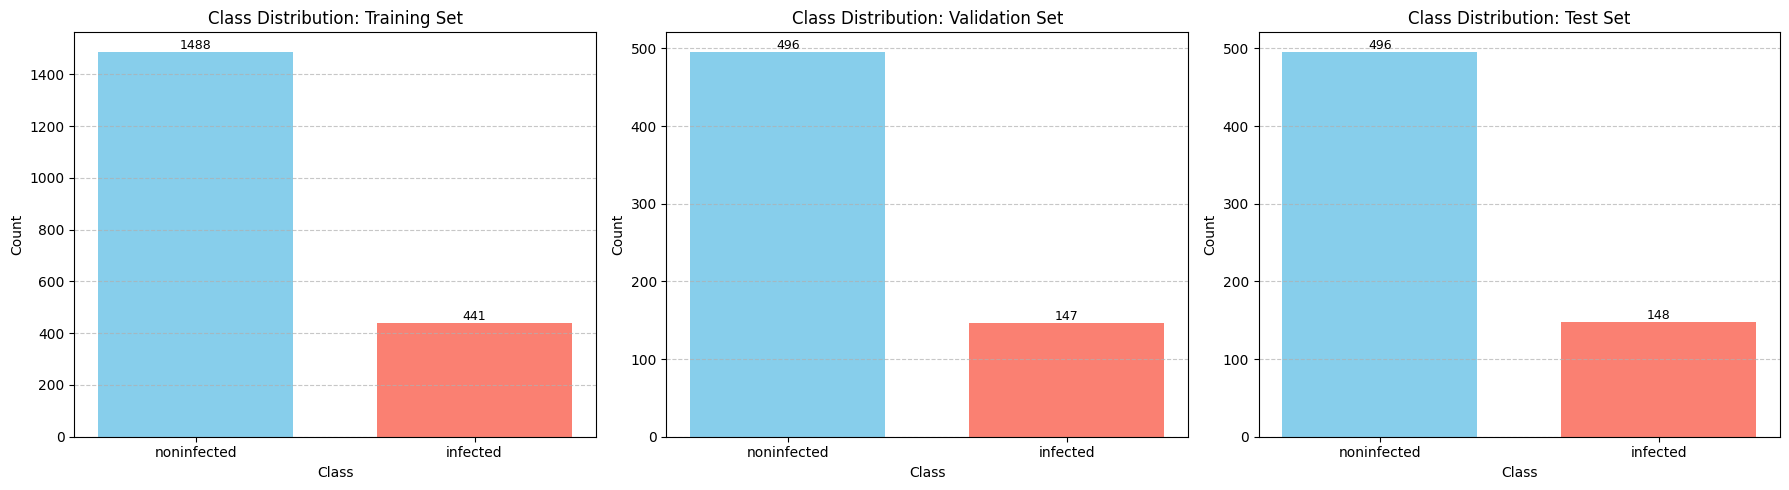

In [17]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot each dataset on its subplot
visualize_class_distribution_subplot(train_generator, "Training Set", axs[0])
visualize_class_distribution_subplot(val_generator, "Validation Set", axs[1])
visualize_class_distribution_subplot(test_generator, "Test Set", axs[2])

plt.tight_layout()
plt.savefig('class_distribution_all_horizontal.png', dpi=300)
plt.show()


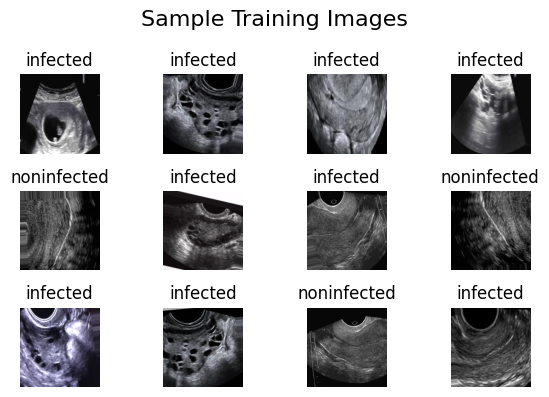

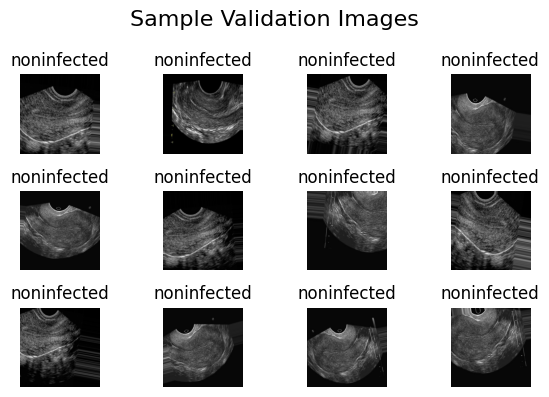

In [18]:
# Visualize sample images
plot_sample_images(train_generator, "Sample Training Images")
plot_sample_images(val_generator, "Sample Validation Images")


In [19]:
# MODEL ARCHITECTURE
# Attention Mechanism Implementation
def channel_attention_module(input_layer, ratio=8):
    channel = input_layer.shape[-1]
    
    # Shared layers for both pooling paths
    shared_layer_one = Dense(channel//ratio, activation='relu', use_bias=True)
    shared_layer_two = Dense(channel, use_bias=True)
    
     # Global Average Pooling path
    avg_pool = GlobalAveragePooling2D()(input_layer)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    # Global Max Pooling Path
    max_pool = GlobalMaxPooling2D()(input_layer)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    # Combine features from both path
    attention = Add()([avg_pool, max_pool])
    attention = Activation('sigmoid')(attention)
    
     # Apply attention weights to input features
    return Multiply()([input_layer, attention])

In [20]:
# Create InceptionV3-based model with optional attention where compiled keras model
def create_inception_model(IMG_SIZE=(299, 299), with_attention=False):
    # Load pre-trained InceptionV3 without top layers
    base_model = applications.InceptionV3(
        include_top=False, 
        weights='imagenet', 
        input_shape=IMG_SIZE + (3,)
    )
    base_model.trainable = False  # Freeze base model
    
    inputs = layers.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs)
    
    # Add attention AFTER base model but BEFORE pooling
    if with_attention:
        x = channel_attention_module(x)
    
    # Global pooling and classification head
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    
    #metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc")
        ]
    )
    return model

In [21]:
 # Create Xception-based model with optional attention 
def create_xception_model(IMG_SIZE=(299, 299), with_attention=False):
    # Load pre-trained Xception without top layers
    base_model = applications.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=IMG_SIZE + (3,)
    )
    base_model.trainable = False  # Freeze base model
    
    inputs = layers.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs)
    
    # Add attention AFTER base model but BEFORE pooling
    if with_attention:
        x = channel_attention_module(x)
    
    # Add BatchNorm and Dropout for better stability
    # x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    
    # Compile with balanced metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
       metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

In [22]:
# Create all model variants to compare
models_dict = {
    "Inception": create_inception_model(),
    "Xception": create_xception_model(),
    "Inception+Attention": create_inception_model(with_attention=True),
    "Xception+Attention": create_xception_model(with_attention=True)
}

In [23]:
results = []  # Store evaluation results
history_dict = {}  # Store training histories

print("\n" + "=" * 60)
print("Starting Model Training")
print("=" * 60)

for model_name, model in models_dict.items():
    print(f"\n{'=' * 40}")
    print(f"Training {model_name}...")
    print(f"{'=' * 40}")

    # Callbacks for training
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),
        ModelCheckpoint(f'best_{model_name}.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
    ]

    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=min(100, train_generator.samples // BATCH_SIZE),
        validation_data=val_generator,
        validation_steps=min(50, val_generator.samples // BATCH_SIZE),
        epochs=EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    # Save training history
    history_dict[model_name] = history

    # Evaluate on test set
    test_generator.reset()
    test_results = model.evaluate(test_generator, verbose=0)

    # # Debug: Print metric names and results
    # print(f"\nEvaluation metrics for {model_name}:")
    # print("Model metric names:", model.metrics_names)
    # print("Test results:", test_results)

    # Handle metrics safely
    if len(test_results) == 5:
        # Expected order: loss, accuracy, precision, recall, auc
        loss, accuracy, precision, recall, auc = test_results
        test_metrics = {
            "loss": loss,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "auc": auc
        }
    elif len(test_results) == 2 and 'compile_metrics' in model.metrics_names:
        # Only loss + compile_metrics (common with some pretrained models)
        loss, accuracy = test_results
        test_metrics = {
            
            "accuracy": accuracy,
            "loss": loss,
            "precision": None,
            "recall": None,
            "auc": None
        }
    else:
        # Generic fallback
        test_metrics = dict(zip(model.metrics_names, test_results))
    # print("Available keys in test_metrics:", list(test_metrics.keys()))

    # Store results for comparison
    results.append({
        'Model': model_name,
        'Test Accuracy': test_metrics['accuracy'],
        'Test Precision': test_metrics['precision'],
        'Test Recall': test_metrics['recall'],
        'Test Loss': test_metrics['loss'],
        'Test AUC': test_metrics['auc']
    })

    # Print test metrics
    print(f"\n{model_name} Test Metrics:")
    for k, v in test_metrics.items():
        if v is not None:
            print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: None")

    # Sample prediction sanity check
    sample_pred = model.predict(test_generator, steps=1)
    print(f"Sample predictions (min/max): {np.min(sample_pred):.4f}/{np.max(sample_pred):.4f}")



Starting Model Training

Training Inception...
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.5599 - auc: 0.5694 - loss: 0.6758 - precision: 0.8019 - recall: 0.5795 
Epoch 1: val_accuracy improved from -inf to 0.72188, saving model to best_Inception.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 855ms/step - accuracy: 0.5605 - auc: 0.5703 - loss: 0.6756 - precision: 0.8022 - recall: 0.5800 - val_accuracy: 0.7219 - val_auc: 0.8079 - val_loss: 0.5653 - val_precision: 0.9112 - val_recall: 0.7079 - learning_rate: 1.0000e-04
Epoch 2/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 44s 559ms/step - accuracy: 0.7653 - auc: 0.8555 - loss: 0.5458 - precision: 0.9628 - recall: 0.7235
Epoch 2: val_accuracy did not improve from 0.72188
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 347ms/step - accuracy: 0.7626 - auc: 0.8494 - loss: 0.5483 - precision: 0.9559 - recall: 0.7245 - val_accuracy: 0.7031 - val_auc: 0.8120 - val_loss: 0.5700 - val_precision: 0.9292 - val_recall: 0.6653 - learning_rate: 1.0000e-04
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.7260 - auc: 0.8244 - loss: 0.5551 - precision: 0.9338 - recall: 0.6889 
Epoch 3: val_accuracy improved from 0.72188 to 0.79375, saving model to best_Inception.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 808ms/step - accuracy: 0.7261 - auc: 0.8246 - loss: 0.5549 - precision: 0.9339 - recall: 0.6890 - val_accuracy: 0.7937 - val_auc: 0.8951 - val_loss: 0.4741 - val_precision: 0.9738 - val_recall: 0.7525 - learning_rate: 1.0000e-04
Epoch 4/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 44s 565ms/step - accuracy: 0.7496 - auc: 0.9123 - loss: 0.4959 - precision: 0.9635 - recall: 0.6774
Epoch 4: val_accuracy did not improve from 0.79375
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 347ms/step - accuracy: 0.7405 - auc: 0.9043 - loss: 0.4855 - precision: 0.9736 - recall: 0.6658 - val_accuracy: 0.7328 - val_auc: 0.8837 - val_loss: 0.5222 - val_precision: 0.9849 - val_recall: 0.6633 - learning_rate: 1.0000e-04
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.7643 - auc: 0.8961 - loss: 0.4484 - precision: 0.9625 - recall: 0.7260 
Epoch 5: val_accuracy did not improve from 0.79375
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 809ms/step - accuracy: 0.7645 - auc: 0.8961 - loss: 0.4483 - 

100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 354ms/step - accuracy: 0.7738 - auc: 0.9161 - loss: 0.4213 - precision: 0.9820 - recall: 0.7141 - val_accuracy: 0.7984 - val_auc: 0.9182 - val_loss: 0.4352 - val_precision: 0.9840 - val_recall: 0.7505 - learning_rate: 1.0000e-04
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.7835 - auc: 0.9149 - loss: 0.4069 - precision: 0.9643 - recall: 0.7526 
Epoch 7: val_accuracy improved from 0.79844 to 0.80000, saving model to best_Inception.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 827ms/step - accuracy: 0.7836 - auc: 0.9150 - loss: 0.4069 - precision: 0.9643 - recall: 0.7527 - val_accuracy: 0.8000 - val_auc: 0.9328 - val_loss: 0.4091 - val_precision: 0.9867 - val_recall: 0.7505 - learning_rate: 1.0000e-04
Epoch 8/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 44s 560ms/step - accuracy: 0.8040 - auc: 0.9304 - loss: 0.3843 - precision: 0.9861 - recall: 0.7587
Epoch 8: val_accuracy improved from 0.80000 to 0.80781, saving model to best_Inception.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 356ms/step - accuracy: 0.7763 - auc: 0.9307 - loss: 0.3951 - precision: 0.9804 - recall: 0.7280 - val_accuracy: 0.8078 - val_auc: 0.9389 - val_loss: 0.3869 - val_precision: 0.9818 - val_recall: 0.7647 - learning_rate: 1.0000e-04
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.8115 - auc: 0.9336 - loss: 0.3777 - precision: 0.9611 - recall: 0.7907 
Epoch 9: val_accuracy improved from 0.80781 to 0.83281, saving model to best_Inception.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 827ms/step - accuracy: 0.8115 - auc: 0.9337 - loss: 0.3777 - precision: 0.9612 - recall: 0.7907 - val_accuracy: 0.8328 - val_auc: 0.9413 - val_loss: 0.3598 - val_precision: 0.9777 - val_recall: 0.8012 - learning_rate: 1.0000e-04
Epoch 10/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 45s 578ms/step - accuracy: 0.8579 - auc: 0.9407 - loss: 0.3413 - precision: 0.9626 - recall: 0.8570
Epoch 10: val_accuracy improved from 0.83281 to 0.85156, saving model to best_Inception.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 375ms/step - accuracy: 0.8620 - auc: 0.9467 - loss: 0.3399 - precision: 0.9656 - recall: 0.8580 - val_accuracy: 0.8516 - val_auc: 0.9490 - val_loss: 0.3439 - val_precision: 0.9716 - val_recall: 0.8316 - learning_rate: 1.0000e-04
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.8273 - auc: 0.9375 - loss: 0.3668 - precision: 0.9668 - recall: 0.8009 
Epoch 11: val_accuracy improved from 0.85156 to 0.86250, saving model to best_Inception.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 832ms/step - accuracy: 0.8272 - auc: 0.9376 - loss: 0.3667 - precision: 0.9669 - recall: 0.8008 - val_accuracy: 0.8625 - val_auc: 0.9504 - val_loss: 0.3234 - val_precision: 0.9720 - val_recall: 0.8458 - learning_rate: 1.0000e-04
Epoch 12/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 45s 574ms/step - accuracy: 0.8534 - auc: 0.9381 - loss: 0.3280 - precision: 0.9583 - recall: 0.8518
Epoch 12: val_accuracy did not improve from 0.86250
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 355ms/step - accuracy: 0.8399 - auc: 0.9416 - loss: 0.3338 - precision: 0.9602 - recall: 0.8323 - val_accuracy: 0.8578 - val_auc: 0.9511 - val_loss: 0.3339 - val_precision: 0.9763 - val_recall: 0.8357 - learning_rate: 1.0000e-04
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.8617 - auc: 0.9633 - loss: 0.3168 - precision: 0.9801 - recall: 0.8394 
Epoch 13: val_accuracy improved from 0.86250 to 0.90938, saving model to best_Inception.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 830ms/step - accuracy: 0.8617 - auc: 0.9633 - loss: 0.3168 - precision: 0.9800 - recall: 0.8393 - val_accuracy: 0.9094 - val_auc: 0.9671 - val_loss: 0.2801 - val_precision: 0.9698 - val_recall: 0.9108 - learning_rate: 1.0000e-04
Epoch 14/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 45s 574ms/step - accuracy: 0.9011 - auc: 0.9659 - loss: 0.3008 - precision: 0.9764 - recall: 0.8959
Epoch 14: val_accuracy did not improve from 0.90938
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 355ms/step - accuracy: 0.8805 - auc: 0.9543 - loss: 0.3293 - precision: 0.9709 - recall: 0.8706 - val_accuracy: 0.8531 - val_auc: 0.9607 - val_loss: 0.3218 - val_precision: 0.9831 - val_recall: 0.8235 - learning_rate: 1.0000e-04
Epoch 15/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.8311 - auc: 0.9590 - loss: 0.3184 - precision: 0.9738 - recall: 0.8028 
Epoch 15: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 15: val_accuracy did not improve from 0.90938
100/100 ━━━

100/100 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.5455 - auc: 0.5626 - loss: 0.6879 - precision: 0.7931 - recall: 0.5520 - val_accuracy: 0.7703 - val_auc: 0.8133 - val_loss: 0.6106 - val_precision: 0.9139 - val_recall: 0.7748 - learning_rate: 1.0000e-04
Epoch 2/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - accuracy: 0.7517 - auc: 0.8156 - loss: 0.5783 - precision: 0.9142 - recall: 0.7585
Epoch 2: val_accuracy improved from 0.77031 to 0.77344, saving model to best_Xception.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 635ms/step - accuracy: 0.7574 - auc: 0.8212 - loss: 0.5922 - precision: 0.9158 - recall: 0.7579 - val_accuracy: 0.7734 - val_auc: 0.8268 - val_loss: 0.5957 - val_precision: 0.9286 - val_recall: 0.7647 - learning_rate: 1.0000e-04
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7689 - auc: 0.8352 - loss: 0.5747 - precision: 0.9453 - recall: 0.7410  
Epoch 3: val_accuracy improved from 0.77344 to 0.79688, saving model to best_Xception.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.7690 - auc: 0.8353 - loss: 0.5745 - precision: 0.9453 - recall: 0.7411 - val_accuracy: 0.7969 - val_auc: 0.8556 - val_loss: 0.5257 - val_precision: 0.9459 - val_recall: 0.7809 - learning_rate: 1.0000e-04
Epoch 4/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - accuracy: 0.8057 - auc: 0.8693 - loss: 0.5095 - precision: 0.9493 - recall: 0.7954
Epoch 4: val_accuracy did not improve from 0.79688
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 633ms/step - accuracy: 0.7970 - auc: 0.8611 - loss: 0.4995 - precision: 0.9569 - recall: 0.7815 - val_accuracy: 0.7875 - val_auc: 0.8603 - val_loss: 0.5135 - val_precision: 0.9407 - val_recall: 0.7728 - learning_rate: 1.0000e-04
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7820 - auc: 0.8752 - loss: 0.5059 - precision: 0.9588 - recall: 0.7505  
Epoch 5: val_accuracy did not improve from 0.79688
100/100 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.7822 - auc: 0.8753 - loss: 0.5057 - precisio

100/100 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8027 - auc: 0.8942 - loss: 0.4662 - precision: 0.9803 - recall: 0.7544 - val_accuracy: 0.8172 - val_auc: 0.9150 - val_loss: 0.4355 - val_precision: 0.9747 - val_recall: 0.7830 - learning_rate: 1.0000e-04
Epoch 8/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - accuracy: 0.7928 - auc: 0.8819 - loss: 0.4783 - precision: 0.9899 - recall: 0.7235
Epoch 8: val_accuracy did not improve from 0.81719
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 647ms/step - accuracy: 0.8131 - auc: 0.9129 - loss: 0.4316 - precision: 0.9863 - recall: 0.7650 - val_accuracy: 0.8172 - val_auc: 0.9193 - val_loss: 0.4268 - val_precision: 0.9796 - val_recall: 0.7789 - learning_rate: 1.0000e-04
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8020 - auc: 0.9189 - loss: 0.4236 - precision: 0.9742 - recall: 0.7665     
Epoch 9: val_accuracy did not improve from 0.81719
100/100 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8022 - auc: 0.9190 - loss: 0.4235 - preci

100/100 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.7807 - auc: 0.9128 - loss: 0.4138 - precision: 0.9757 - recall: 0.7333 - val_accuracy: 0.8344 - val_auc: 0.9442 - val_loss: 0.3854 - val_precision: 0.9949 - val_recall: 0.7890 - learning_rate: 1.0000e-04
Epoch 12/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 1:22 1s/step - accuracy: 0.7970 - auc: 0.9368 - loss: 0.3974 - precision: 0.9678 - recall: 0.7565
Epoch 12: val_accuracy did not improve from 0.83438
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 636ms/step - accuracy: 0.8092 - auc: 0.9408 - loss: 0.3977 - precision: 0.9691 - recall: 0.7665 - val_accuracy: 0.8172 - val_auc: 0.9477 - val_loss: 0.3858 - val_precision: 0.9896 - val_recall: 0.7708 - learning_rate: 1.0000e-04
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8103 - auc: 0.9381 - loss: 0.3842 - precision: 0.9703 - recall: 0.7724  
Epoch 13: val_accuracy did not improve from 0.83438
100/100 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.8104 - auc: 0.9381 - loss: 0.3841 - prec

100/100 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8108 - auc: 0.9561 - loss: 0.3533 - precision: 0.9833 - recall: 0.7693 - val_accuracy: 0.8594 - val_auc: 0.9608 - val_loss: 0.3408 - val_precision: 0.9855 - val_recall: 0.8296 - learning_rate: 1.0000e-04
Epoch 16/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 1:22 1s/step - accuracy: 0.8435 - auc: 0.9131 - loss: 0.3355 - precision: 0.9805 - recall: 0.8218
Epoch 16: val_accuracy did not improve from 0.85938
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 649ms/step - accuracy: 0.8425 - auc: 0.9444 - loss: 0.3446 - precision: 0.9744 - recall: 0.8203 - val_accuracy: 0.8531 - val_auc: 0.9653 - val_loss: 0.3348 - val_precision: 0.9807 - val_recall: 0.8256 - learning_rate: 1.0000e-04
Epoch 17/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8430 - auc: 0.9625 - loss: 0.3448 - precision: 0.9845 - recall: 0.8059  
Epoch 17: val_accuracy did not improve from 0.85938
100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.8430 - auc: 0.9625 - loss: 0.3448 - prec

100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 687ms/step - accuracy: 0.8583 - auc: 0.9756 - loss: 0.2994 - precision: 0.9853 - recall: 0.8326 - val_accuracy: 0.8641 - val_auc: 0.9646 - val_loss: 0.3231 - val_precision: 0.9903 - val_recall: 0.8316 - learning_rate: 1.0000e-04
Epoch 19/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8528 - auc: 0.9619 - loss: 0.3221 - precision: 0.9738 - recall: 0.8327  
Epoch 19: val_accuracy did not improve from 0.86406
100/100 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.8528 - auc: 0.9619 - loss: 0.3221 - precision: 0.9738 - recall: 0.8326 - val_accuracy: 0.8531 - val_auc: 0.9694 - val_loss: 0.3266 - val_precision: 0.9902 - val_recall: 0.8174 - learning_rate: 1.0000e-04
Epoch 20/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - accuracy: 0.8206 - auc: 0.9607 - loss: 0.3249 - precision: 0.9890 - recall: 0.7834
Epoch 20: val_accuracy improved from 0.86406 to 0.86719, saving model to best_Xception.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 691ms/step - accuracy: 0.8354 - auc: 0.9613 - loss: 0.3221 - precision: 0.9831 - recall: 0.8037 - val_accuracy: 0.8672 - val_auc: 0.9695 - val_loss: 0.3152 - val_precision: 0.9904 - val_recall: 0.8357 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 20.

Xception Test Metrics:
loss: 0.3562
accuracy: 0.8230
precision: 0.9823
recall: 0.7843
auc: 0.9525
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Sample predictions (min/max): 0.1166/0.5831

Training Inception+Attention...
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.7291 - auc: 0.8216 - loss: 0.5420 - precision: 0.9154 - recall: 0.7119  
Epoch 1: val_accuracy improved from -inf to 0.88750, saving model to best_Inception+Attention.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.7298 - auc: 0.8225 - loss: 0.5410 - precision: 0.9158 - recall: 0.7125 - val_accuracy: 0.8875 - val_auc: 0.9655 - val_loss: 0.2793 - val_precision: 0.9626 - val_recall: 0.8884 - learning_rate: 1.0000e-04
Epoch 2/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 54s 688ms/step - accuracy: 0.8409 - auc: 0.9454 - loss: 0.3407 - precision: 0.9544 - recall: 0.8300 
Epoch 2: val_accuracy did not improve from 0.88750
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 417ms/step - accuracy: 0.8396 - auc: 0.9474 - loss: 0.3365 - precision: 0.9504 - recall: 0.8279 - val_accuracy: 0.8141 - val_auc: 0.9653 - val_loss: 0.3604 - val_precision: 0.9895 - val_recall: 0.7667 - learning_rate: 1.0000e-04
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.8738 - auc: 0.9666 - loss: 0.2707 - precision: 0.9849 - recall: 0.8499  
Epoch 3: val_accuracy improved from 0.88750 to 0.90938, saving model to best_Inception+Attention.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 99s 992ms/step - accuracy: 0.8740 - auc: 0.9666 - loss: 0.2706 - precision: 0.9849 - recall: 0.8501 - val_accuracy: 0.9094 - val_auc: 0.9787 - val_loss: 0.2174 - val_precision: 0.9823 - val_recall: 0.8986 - learning_rate: 1.0000e-04
Epoch 4/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 54s 695ms/step - accuracy: 0.8692 - auc: 0.9703 - loss: 0.2329 - precision: 0.9744 - recall: 0.8572 
Epoch 4: val_accuracy did not improve from 0.90938
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 420ms/step - accuracy: 0.8855 - auc: 0.9686 - loss: 0.2360 - precision: 0.9745 - recall: 0.8762 - val_accuracy: 0.8375 - val_auc: 0.9756 - val_loss: 0.3049 - val_precision: 0.9924 - val_recall: 0.7951 - learning_rate: 1.0000e-04
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.8931 - auc: 0.9713 - loss: 0.2270 - precision: 0.9744 - recall: 0.8866  
Epoch 5: val_accuracy improved from 0.90938 to 0.92344, saving model to best_Inception+Attention.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 99s 989ms/step - accuracy: 0.8931 - auc: 0.9712 - loss: 0.2270 - precision: 0.9744 - recall: 0.8865 - val_accuracy: 0.9234 - val_auc: 0.9823 - val_loss: 0.1726 - val_precision: 0.9173 - val_recall: 0.9899 - learning_rate: 1.0000e-04
Epoch 6/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 54s 696ms/step - accuracy: 0.9370 - auc: 0.9860 - loss: 0.2164 - precision: 0.9824 - recall: 0.9365 
Epoch 6: val_accuracy improved from 0.92344 to 0.92500, saving model to best_Inception+Attention.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 430ms/step - accuracy: 0.9256 - auc: 0.9840 - loss: 0.1970 - precision: 0.9805 - recall: 0.9243 - val_accuracy: 0.9250 - val_auc: 0.9837 - val_loss: 0.1854 - val_precision: 0.9847 - val_recall: 0.9168 - learning_rate: 1.0000e-04
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.9099 - auc: 0.9769 - loss: 0.2057 - precision: 0.9787 - recall: 0.9015  
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 7: val_accuracy did not improve from 0.92500
100/100 ━━━━━━━━━━━━━━━━━━━━ 99s 990ms/step - accuracy: 0.9100 - auc: 0.9769 - loss: 0.2057 - precision: 0.9786 - recall: 0.9015 - val_accuracy: 0.8641 - val_auc: 0.9814 - val_loss: 0.2743 - val_precision: 0.9903 - val_recall: 0.8316 - learning_rate: 1.0000e-04
Epoch 8/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 52s 668ms/step - accuracy: 0.8452 - auc: 0.9946 - loss: 0.1786 - precision: 0.9976 - recall: 0.8209
Epoch 8: val_accuracy improved from 0.92500 to 0.96094, saving mod

100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 420ms/step - accuracy: 0.8786 - auc: 0.9886 - loss: 0.1644 - precision: 0.9930 - recall: 0.8626 - val_accuracy: 0.9609 - val_auc: 0.9935 - val_loss: 0.1174 - val_precision: 0.9756 - val_recall: 0.9736 - learning_rate: 2.0000e-05
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.9206 - auc: 0.9801 - loss: 0.1905 - precision: 0.9725 - recall: 0.9239  
Epoch 9: val_accuracy did not improve from 0.96094
100/100 ━━━━━━━━━━━━━━━━━━━━ 98s 979ms/step - accuracy: 0.9207 - auc: 0.9801 - loss: 0.1904 - precision: 0.9726 - recall: 0.9239 - val_accuracy: 0.9438 - val_auc: 0.9917 - val_loss: 0.1427 - val_precision: 0.9831 - val_recall: 0.9432 - learning_rate: 2.0000e-05
Epoch 10/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 55s 700ms/step - accuracy: 0.9163 - auc: 0.9800 - loss: 0.1934 - precision: 0.9692 - recall: 0.9201 
Epoch 10: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 10: val_accuracy did not improve from 0.96094
100/100 ━━━━

100/100 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.6311 - auc: 0.7422 - loss: 0.6132 - precision: 0.8876 - recall: 0.5843 - val_accuracy: 0.8750 - val_auc: 0.9601 - val_loss: 0.3357 - val_precision: 0.9725 - val_recall: 0.8621 - learning_rate: 1.0000e-04
Epoch 2/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.7949 - auc: 0.9351 - loss: 0.4229 - precision: 0.9719 - recall: 0.7387
Epoch 2: val_accuracy did not improve from 0.87500
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 718ms/step - accuracy: 0.8041 - auc: 0.9453 - loss: 0.3971 - precision: 0.9856 - recall: 0.7436 - val_accuracy: 0.8438 - val_auc: 0.9681 - val_loss: 0.3383 - val_precision: 0.9925 - val_recall: 0.8032 - learning_rate: 1.0000e-04
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8601 - auc: 0.9621 - loss: 0.3055 - precision: 0.9771 - recall: 0.8413  
Epoch 3: val_accuracy improved from 0.87500 to 0.90000, saving model to best_Xception+Attention.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.8603 - auc: 0.9621 - loss: 0.3053 - precision: 0.9771 - recall: 0.8416 - val_accuracy: 0.9000 - val_auc: 0.9805 - val_loss: 0.2502 - val_precision: 0.9886 - val_recall: 0.8803 - learning_rate: 1.0000e-04
Epoch 4/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 1:32 1s/step - accuracy: 0.8927 - auc: 0.9775 - loss: 0.2272 - precision: 0.9839 - recall: 0.8847
Epoch 4: val_accuracy did not improve from 0.90000
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 703ms/step - accuracy: 0.8958 - auc: 0.9719 - loss: 0.2422 - precision: 0.9764 - recall: 0.8894 - val_accuracy: 0.7906 - val_auc: 0.9770 - val_loss: 0.3756 - val_precision: 1.0000 - val_recall: 0.7282 - learning_rate: 1.0000e-04
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8692 - auc: 0.9691 - loss: 0.2494 - precision: 0.9748 - recall: 0.8549  
Epoch 5: val_accuracy improved from 0.90000 to 0.91875, saving model to best_Xception+Attention.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.8695 - auc: 0.9691 - loss: 0.2492 - precision: 0.9748 - recall: 0.8553 - val_accuracy: 0.9187 - val_auc: 0.9907 - val_loss: 0.2028 - val_precision: 0.9977 - val_recall: 0.8966 - learning_rate: 1.0000e-04
Epoch 6/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.9191 - auc: 0.9904 - loss: 0.1823 - precision: 0.9866 - recall: 0.9023
Epoch 6: val_accuracy improved from 0.91875 to 0.93125, saving model to best_Xception+Attention.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 714ms/step - accuracy: 0.9148 - auc: 0.9896 - loss: 0.1782 - precision: 0.9903 - recall: 0.8958 - val_accuracy: 0.9312 - val_auc: 0.9868 - val_loss: 0.1882 - val_precision: 0.9934 - val_recall: 0.9168 - learning_rate: 1.0000e-04
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9301 - auc: 0.9837 - loss: 0.1812 - precision: 0.9829 - recall: 0.9251  
Epoch 7: val_accuracy improved from 0.93125 to 0.95000, saving model to best_Xception+Attention.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.9300 - auc: 0.9837 - loss: 0.1813 - precision: 0.9829 - recall: 0.9250 - val_accuracy: 0.9500 - val_auc: 0.9919 - val_loss: 0.1487 - val_precision: 0.9936 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 8/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - accuracy: 0.8850 - auc: 0.9786 - loss: 0.2081 - precision: 0.9699 - recall: 0.8689
Epoch 8: val_accuracy did not improve from 0.95000
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 708ms/step - accuracy: 0.8912 - auc: 0.9789 - loss: 0.2029 - precision: 0.9763 - recall: 0.8757 - val_accuracy: 0.9484 - val_auc: 0.9870 - val_loss: 0.1455 - val_precision: 0.9812 - val_recall: 0.9513 - learning_rate: 1.0000e-04
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9201 - auc: 0.9820 - loss: 0.1797 - precision: 0.9786 - recall: 0.9169  
Epoch 9: val_accuracy did not improve from 0.95000
100/100 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.9201 - auc: 0.9820 - loss: 0.1797 - precisio

100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 711ms/step - accuracy: 0.9236 - auc: 0.9898 - loss: 0.1476 - precision: 0.9888 - recall: 0.9143 - val_accuracy: 0.9516 - val_auc: 0.9904 - val_loss: 0.1346 - val_precision: 0.9873 - val_recall: 0.9493 - learning_rate: 1.0000e-04
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9360 - auc: 0.9885 - loss: 0.1500 - precision: 0.9918 - recall: 0.9235  
Epoch 11: val_accuracy did not improve from 0.95156
100/100 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.9360 - auc: 0.9885 - loss: 0.1501 - precision: 0.9917 - recall: 0.9235 - val_accuracy: 0.9484 - val_auc: 0.9912 - val_loss: 0.1294 - val_precision: 0.9873 - val_recall: 0.9452 - learning_rate: 1.0000e-04
Epoch 12/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - accuracy: 0.9252 - auc: 0.9859 - loss: 0.1537 - precision: 0.9929 - recall: 0.9132
Epoch 12: val_accuracy improved from 0.95156 to 0.95938, saving model to best_Xception+Attention.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 727ms/step - accuracy: 0.9185 - auc: 0.9824 - loss: 0.1694 - precision: 0.9890 - recall: 0.9089 - val_accuracy: 0.9594 - val_auc: 0.9918 - val_loss: 0.1203 - val_precision: 0.9854 - val_recall: 0.9615 - learning_rate: 1.0000e-04
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9355 - auc: 0.9861 - loss: 0.1561 - precision: 0.9849 - recall: 0.9299  
Epoch 13: val_accuracy did not improve from 0.95938
100/100 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.9355 - auc: 0.9861 - loss: 0.1561 - precision: 0.9849 - recall: 0.9300 - val_accuracy: 0.9594 - val_auc: 0.9923 - val_loss: 0.1067 - val_precision: 0.9642 - val_recall: 0.9838 - learning_rate: 1.0000e-04
Epoch 14/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.9392 - auc: 0.9739 - loss: 0.2075 - precision: 0.9671 - recall: 0.9590
Epoch 14: val_accuracy improved from 0.95938 to 0.96406, saving model to best_Xception+Attention.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 722ms/step - accuracy: 0.9379 - auc: 0.9836 - loss: 0.1643 - precision: 0.9802 - recall: 0.9395 - val_accuracy: 0.9641 - val_auc: 0.9904 - val_loss: 0.1161 - val_precision: 0.9835 - val_recall: 0.9696 - learning_rate: 1.0000e-04
Epoch 15/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9404 - auc: 0.9898 - loss: 0.1380 - precision: 0.9814 - recall: 0.9392  
Epoch 15: val_accuracy improved from 0.96406 to 0.96562, saving model to best_Xception+Attention.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9403 - auc: 0.9898 - loss: 0.1381 - precision: 0.9814 - recall: 0.9391 - val_accuracy: 0.9656 - val_auc: 0.9919 - val_loss: 0.1012 - val_precision: 0.9758 - val_recall: 0.9797 - learning_rate: 1.0000e-04
Epoch 16/20
 21/100 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.9370 - auc: 0.9800 - loss: 0.2028 - precision: 0.9640 - recall: 0.9563
Epoch 16: val_accuracy did not improve from 0.96562
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 711ms/step - accuracy: 0.9398 - auc: 0.9874 - loss: 0.1500 - precision: 0.9768 - recall: 0.9456 - val_accuracy: 0.9531 - val_auc: 0.9929 - val_loss: 0.1232 - val_precision: 0.9978 - val_recall: 0.9412 - learning_rate: 1.0000e-04
Epoch 17/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9377 - auc: 0.9911 - loss: 0.1280 - precision: 0.9904 - recall: 0.9287  
Epoch 17: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 17: val_accuracy did not improve from 0.96562
100/100 ━━━━━━━━━

In [24]:
# Results Comparison DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("Model Comparison Results:")
print("="*60)
print(results_df)


Model Comparison Results:
                 Model  Test Accuracy  Test Precision  Test Recall  Test Loss  \
0            Inception       0.860248        0.953125     0.860887   0.318321   
1             Xception       0.822981        0.982323     0.784274   0.356167   
2  Inception+Attention       0.950311        0.969636     0.965726   0.146166   
3   Xception+Attention       0.951863        0.977413     0.959677   0.128744   

   Test AUC  
0  0.950264  
1  0.952512  
2  0.986234  
3  0.988503  


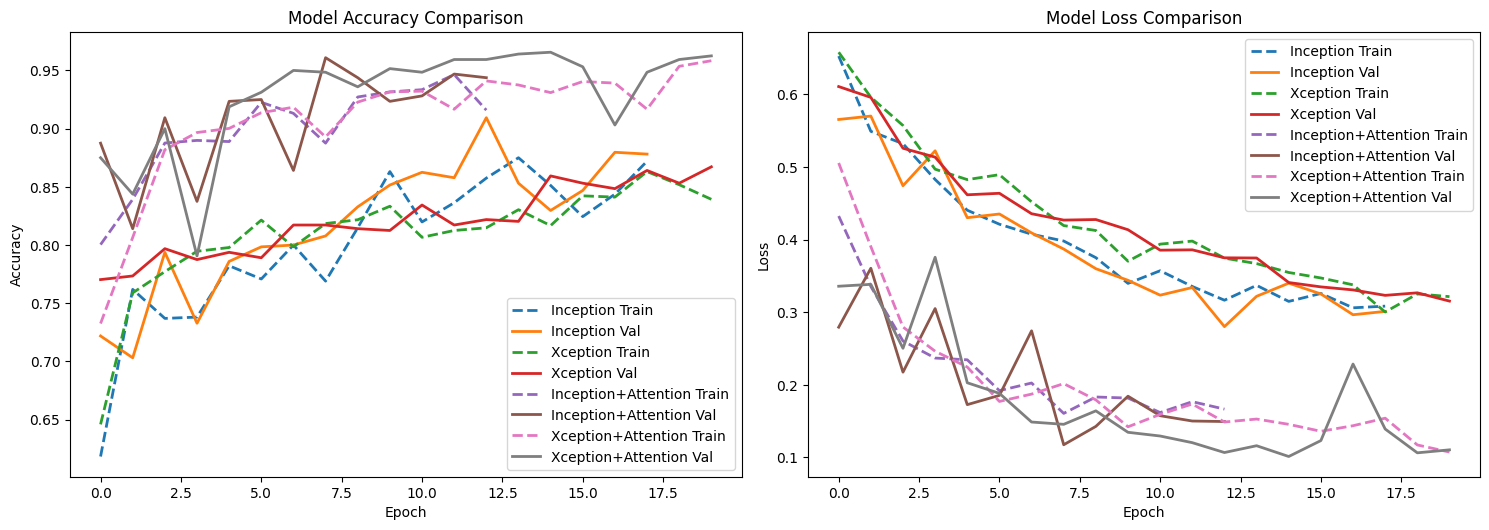

In [25]:
# Visualization 1: Training History Comparison
plt.figure(figsize=(15, 10))

for i, model_name in enumerate(history_dict.keys()):
    history = history_dict[model_name]
    
    # Accuracy plot
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], '--', linewidth=2, label=f'{model_name} Train')
    plt.plot(history.history['val_accuracy'], '-', linewidth=2, label=f'{model_name} Val')
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    
    # Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], '--', linewidth=2, label=f'{model_name} Train')
    plt.plot(history.history['val_loss'], '-', linewidth=2, label=f'{model_name} Val')
    plt.title('Model Loss Comparison')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('training_comparison.png', dpi=300)
plt.show()

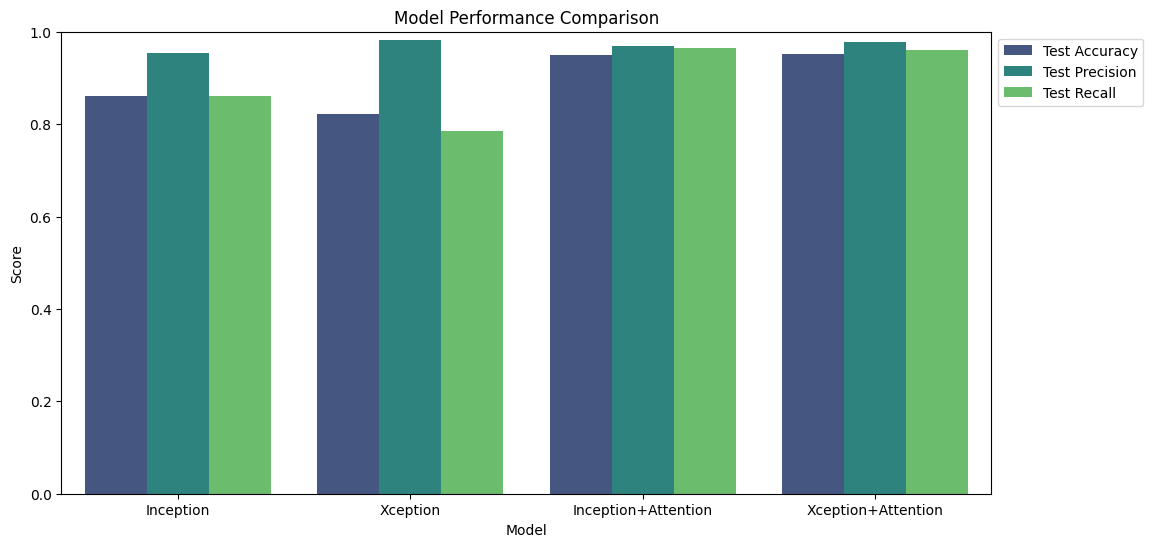

In [26]:
# Visualization 2: Performance Metrics Comparison
metrics_df = results_df.melt(id_vars='Model', 
                             value_vars=['Test Accuracy', 'Test Precision', 'Test Recall'],
                             var_name='Metric', 
                             value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_df, palette='viridis')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 658ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 669ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step


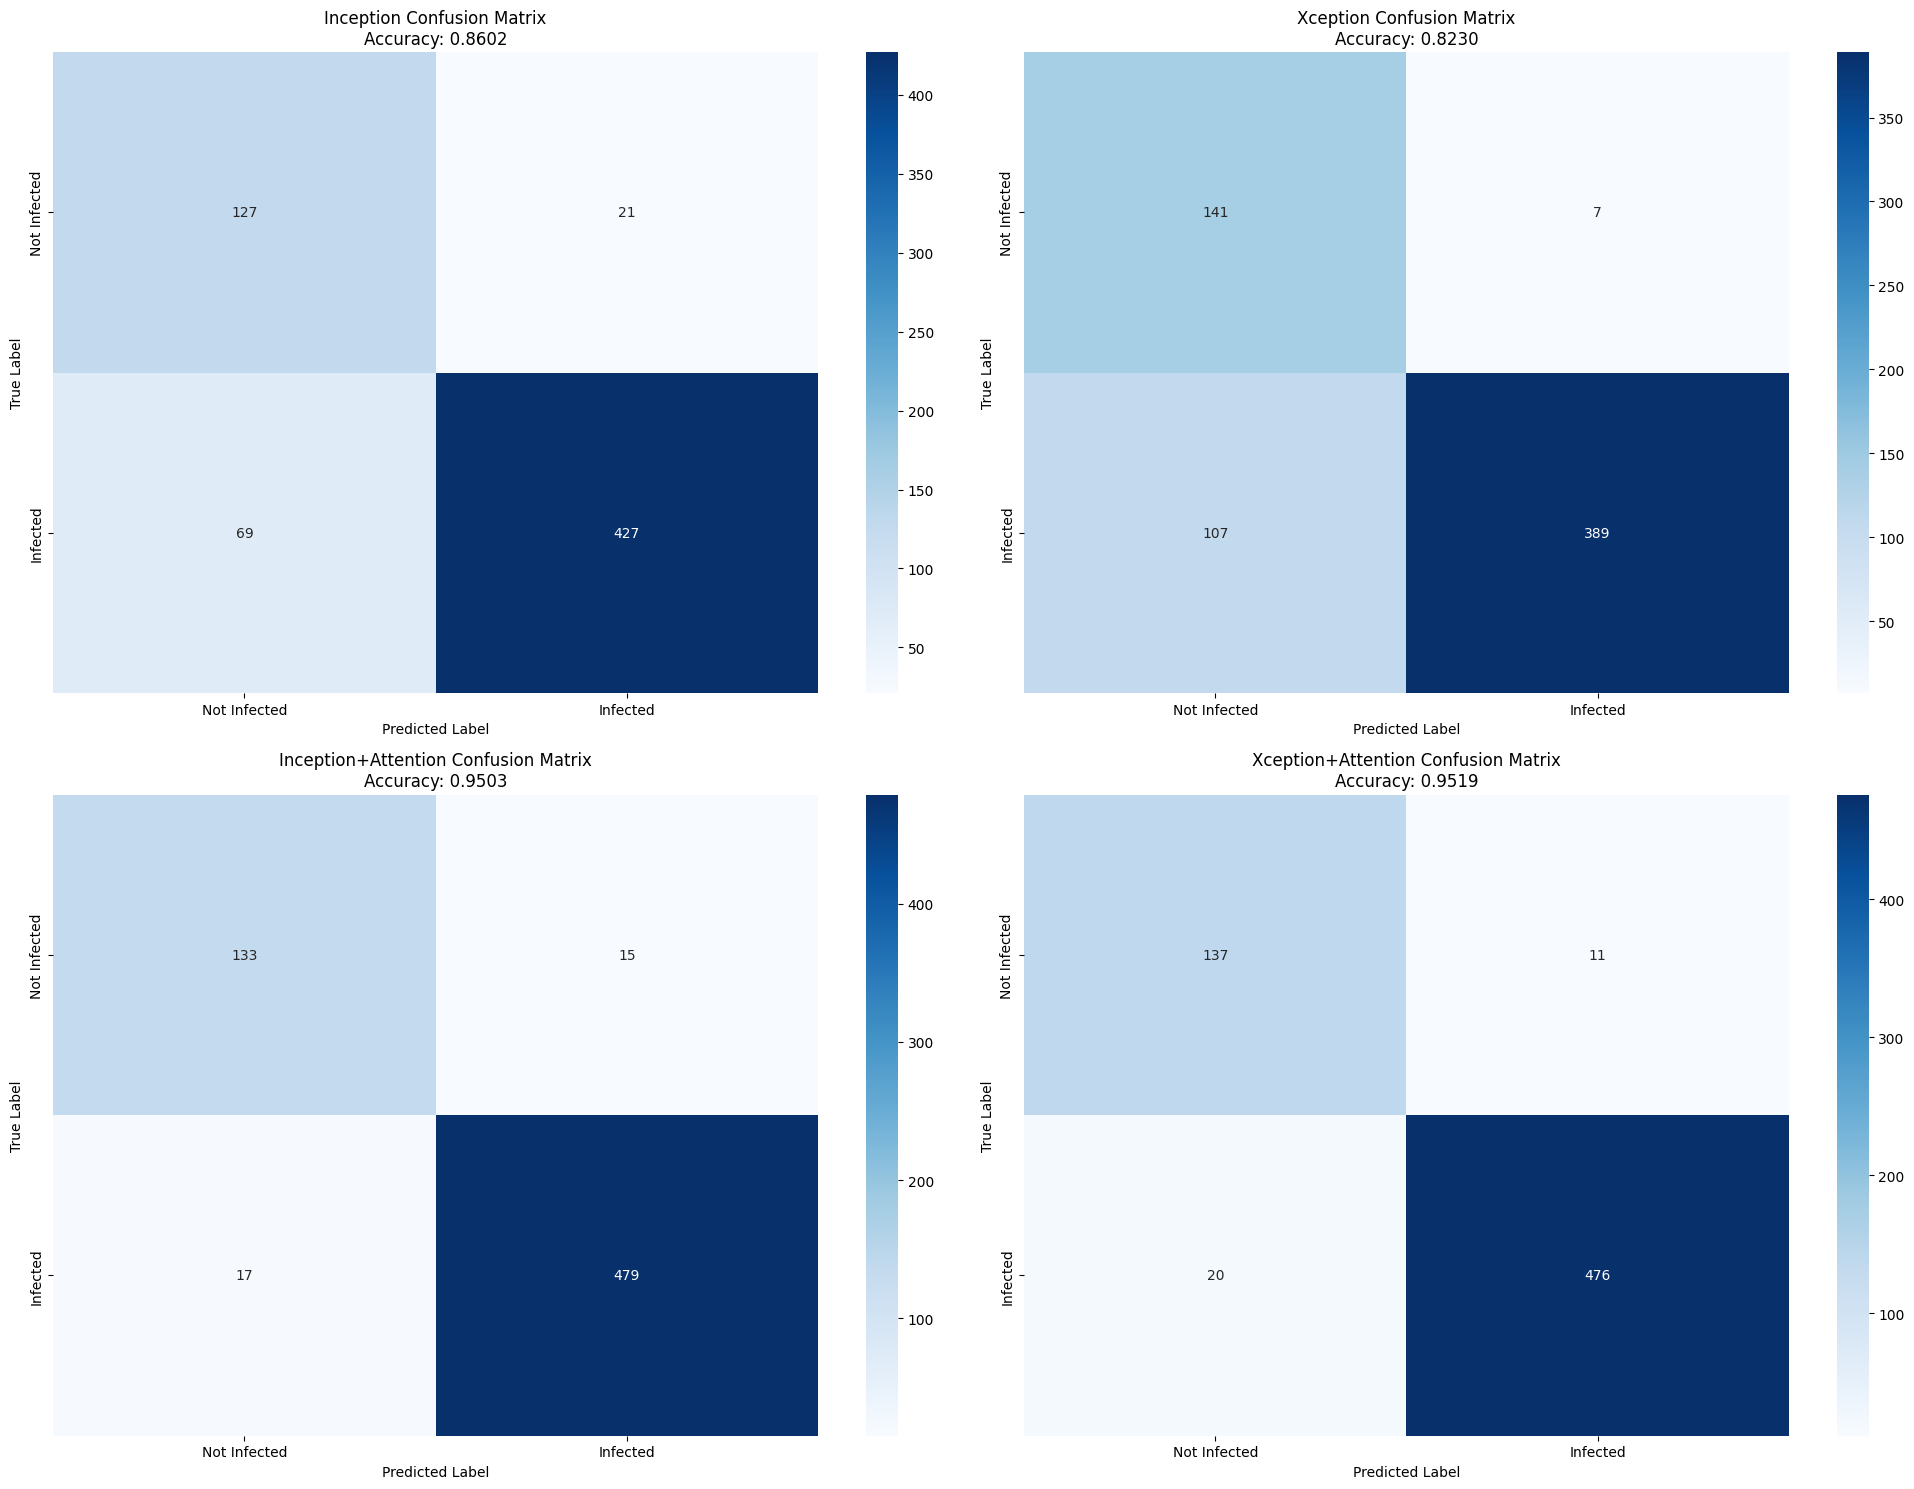

In [27]:
# Visualization 3: Confusion Matrices
plt.figure(figsize=(20, 15))

for i, (model_name, model) in enumerate(models_dict.items()):
    # Predictions
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_pred_classes = (y_pred > 0.5).astype(int)
    y_true = test_generator.classes
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    plt.subplot(2, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Infected', 'Infected'],
                yticklabels=['Not Infected', 'Infected'])
    plt.title(f'{model_name} Confusion Matrix\nAccuracy: {results_df[results_df["Model"]==model_name]["Test Accuracy"].values[0]:.4f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrix_comparison.png', dpi=300)
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 606ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 610ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step


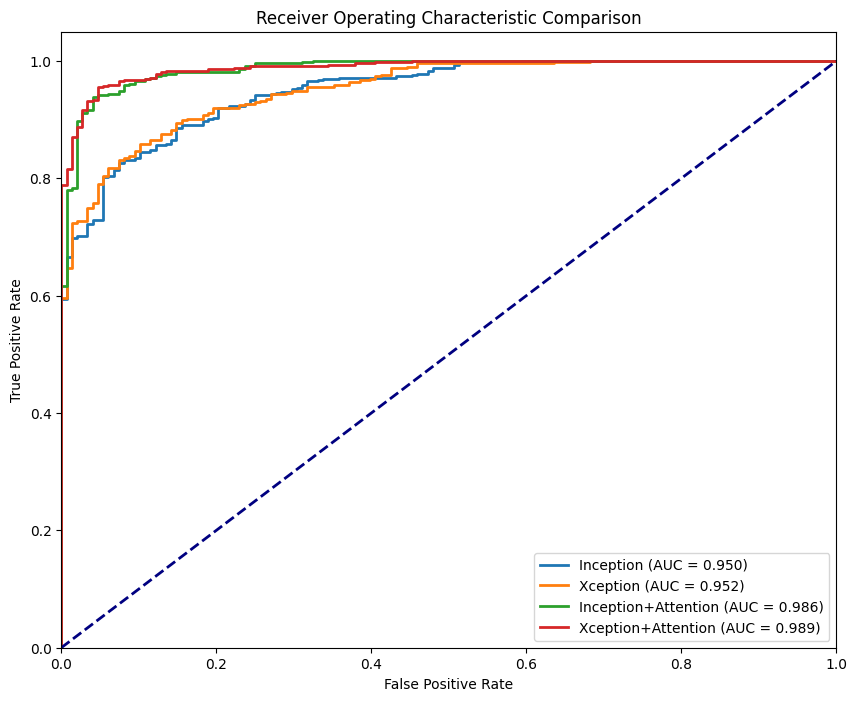

In [28]:
from sklearn.metrics import roc_curve, auc

# Visualization 4: ROC Curve Comparison
plt.figure(figsize=(10, 8))

for model_name, model in models_dict.items():
    # Predict probabilities
    test_generator.reset()
    y_pred_probs = model.predict(test_generator)
    y_true = test_generator.classes
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, 
             label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Comparison')
plt.legend(loc="lower right")
plt.savefig('roc_comparison.png', dpi=300)
plt.show()


In [29]:
# Visualization 5: Attention Visualization (Best Model)
# Determine best model
best_model_name = results_df.loc[results_df['Test Accuracy'].idxmax(), 'Model']
best_model = models_dict[best_model_name]

print("\n" + "="*60)
print(f"Best Model: {best_model_name}")
print("="*60)



Best Model: Xception+Attention


In [30]:
def generate_grad_cam(model, img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Find last convolutional layer
    last_conv_layer = None
    for layer in model.layers[::-1]:
        try:
            if isinstance(layer, tf.keras.layers.Conv2D) or \
               (hasattr(layer.output, 'shape') and len(layer.output.shape) == 4):
                last_conv_layer = layer
                break
        except Exception:
            continue

    if last_conv_layer is None:
        print("No convolutional layer found.")
        return img_array[0], np.zeros((*IMG_SIZE, 3))

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    heatmap = cv2.resize(heatmap, IMG_SIZE)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)


C:\Users\Slug\AppData\Local\Temp\ipykernel_16220\231946870.py:39: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


Saved visualization to: attention_visualizations/attention_Xception+Attention.png


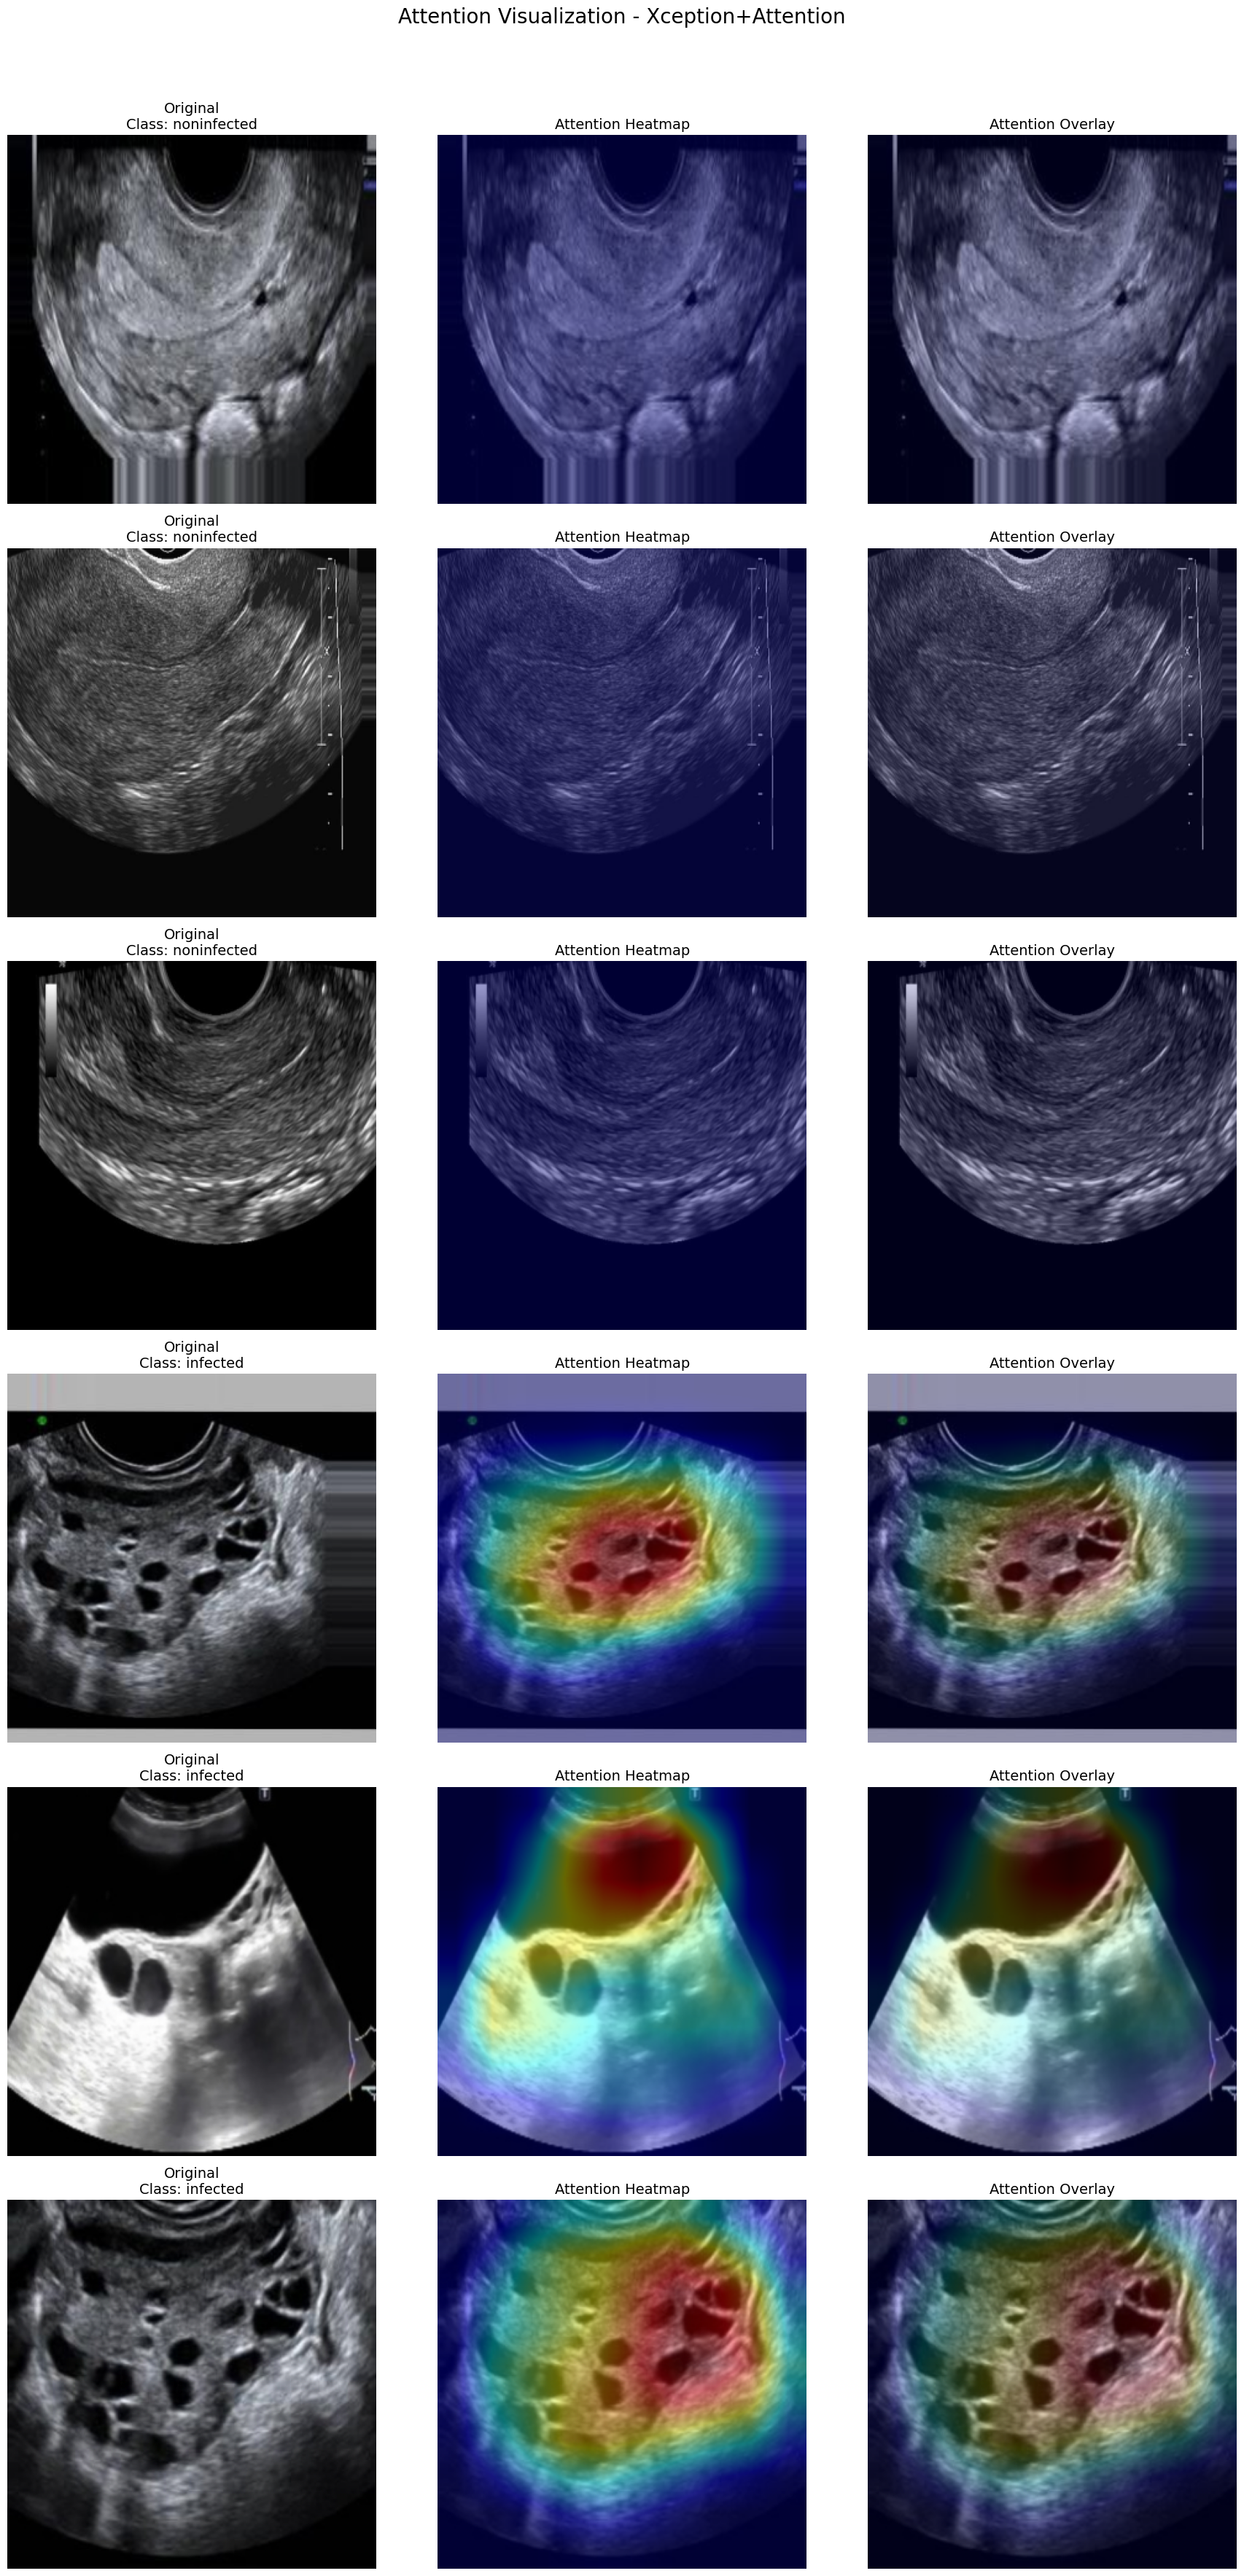

In [33]:
def visualize_attention_samples(model, model_name, test_dir, num_samples=3, img_size=(224, 224)):
    """
    Visualize attention samples for a model with enhanced error handling
    Args:
        model: Trained Keras model
        model_name: Name of model for title
        test_dir: Directory containing test images
        num_samples: Number of samples per class to visualize
        img_size: Size for display
    """
    total_rows = 2 * num_samples
    fig, axs = plt.subplots(total_rows, 3, figsize=(18, total_rows * 6))
    
    if total_rows == 1:
        axs = axs.reshape(1, -1)
    else:
        axs = axs.reshape(total_rows, 3)
    
    fig.suptitle(f'Attention Visualization - {model_name}', fontsize=20)
    
    for class_idx, class_name in enumerate(['noninfected', 'infected']):
        class_dir = os.path.join(test_dir, class_name)
        
        if not os.path.exists(class_dir):
            print(f"Directory missing: {class_dir}")
            for j in range(num_samples):
                row_idx = class_idx * num_samples + j
                placeholder = np.zeros((*img_size, 3), dtype=np.uint8)
                for col in range(3):
                    axs[row_idx, col].imshow(placeholder)
                    axs[row_idx, col].axis('off')
                axs[row_idx, 0].set_title(f"Error: {class_name}\n(Dir missing)", fontsize=12)
            continue
            
        try:
            all_files = [f for f in os.listdir(class_dir) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            if len(all_files) == 0:
                print(f"No images found in: {class_dir}")
                for j in range(num_samples):
                    row_idx = class_idx * num_samples + j
                    placeholder = np.zeros((*img_size, 3), dtype=np.uint8)
                    for col in range(3):
                        axs[row_idx, col].imshow(placeholder)
                        axs[row_idx, col].axis('off')
                    axs[row_idx, 0].set_title(f"Error: {class_name}\n(No images)", fontsize=12)
                continue
                
            sample_files = np.random.choice(
                all_files, 
                size=min(num_samples, len(all_files)), 
                replace=False
            ) if len(all_files) >= num_samples else np.random.choice(
                all_files, size=num_samples, replace=True
            )
            
            for j, file in enumerate(sample_files):
                img_path = os.path.join(class_dir, file)
                row_idx = class_idx * num_samples + j
                
                try:
                    original, attention_img = generate_grad_cam(model, img_path)
                    
                    axs[row_idx, 0].imshow(original)
                    axs[row_idx, 0].set_title(f"Original\nClass: {class_name}", fontsize=14)
                    axs[row_idx, 0].axis('off')
                    
                    axs[row_idx, 1].imshow(attention_img)
                    axs[row_idx, 1].set_title("Attention Heatmap", fontsize=14)
                    axs[row_idx, 1].axis('off')
                    
                    axs[row_idx, 2].imshow(original)
                    axs[row_idx, 2].imshow(attention_img, alpha=0.5)
                    axs[row_idx, 2].set_title("Attention Overlay", fontsize=14)
                    axs[row_idx, 2].axis('off')
                    
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
                    try:
                        original = np.array(Image.open(img_path).resize(img_size))
                    except:
                        original = np.zeros((*img_size, 3), dtype=np.uint8)
                    
                    placeholder = np.zeros((*img_size, 3), dtype=np.uint8)
                    for col in range(3):
                        axs[row_idx, col].imshow(original if col == 0 else placeholder)
                        axs[row_idx, col].axis('off')
                    axs[row_idx, 0].set_title(f"Error: {class_name}\n{file}", fontsize=12)
                    axs[row_idx, 1].set_title("Processing Failed", fontsize=12)
                    
        except Exception as e:
            print(f"Critical error with {class_dir}: {str(e)}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    os.makedirs("attention_visualizations", exist_ok=True)
    save_path = f"attention_visualizations/attention_{model_name}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved visualization to: {save_path}")
    plt.show()

# Generate attention visualizations for best model
DATA_PATH = "new_data"
visualize_attention_samples(
    best_model,
    best_model_name,
    test_dir=os.path.join(DATA_PATH, "test"),
    num_samples=3,
    img_size=(299, 299)
)
